# 構建自動編碼器(Autoencoder)

注意: 這篇文章的內容需要一些對Keras的理解, 這先確認你/妳己先閱讀並練習過以下的連結內容:

* [1.1-keras-functional-api](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.1-keras-functional-api.ipynb)

為了獲得最好的學習效果與理解, 強烈建議先行聆聽以下的線上課程:
* [台大李宏毅 - (ML Lecture 16: Unsupervised Learning - Auto-encoder)](https://www.youtube.com/watch?v=Tk5B4seA-AU&lc=z13atbuzfxjtzx1nf23iw5thtrrdxjnga04)

在本教程中，我們將回答關於autoencoders的一些常見問題，我們將介紹以下模型的代碼示例：
* 一個基於完全連接層(fully-connected layer)的簡單的自動編碼器
* 一個深度完全連接(deep fully-connected)的自動編碼器
* 一個深度卷積(deep convolutional)自動編碼器
* 圖像去噪(denoising)模型

## 什麼是自動編碼器？

![auto-encoder](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

“自動編碼(Autoencoding)”是一種數據壓縮算法，其中壓縮和解壓縮功能是:
1. 針對特定的數據
2. 有損的
3. 自動從數據中學習而不是由人工設計

另外，在幾乎所有使用術語“自動編碼器”的情況下，壓縮和解壓縮功能都是用神經網絡來實現的。

### 1. 針對特定的數據

自動編碼器是針對特定的數據，這意味著它們只能壓縮類似於他們所訓練的數據。這與例如MPEG-2音頻層壓縮算法不同，後者通常只保留關於“聲音”的假設，而不涉及特定類型的聲音。在"臉部"圖片上訓練的自動編碼器在壓縮"樹"的圖片方面做得相當差，因為它將學習的特徵是"臉部"特定的。

### 2. 有損的

自動編碼器是有損失的壓縮，這意味著與原始輸入相比，解壓縮的輸出會降低（類似於MP3或JPEG壓縮）。這與無損壓縮算法不同。

### 3. 自動從數據中學習而不是由人工設計

自動編碼器是從數據中自動學習的，這是一很有用的特性：這意味著很容易訓練出特定的算法實例，在特定類型的輸入上運行良好。它不需要任何新的工程，只需要適當的訓練數據。

要構建一個自動編碼器，需要三件事：編碼函數，解碼函數和數據壓縮表示與解壓縮表示（即“丟失”函數）之間的信息損失量之間的距離函數。

編碼器和解碼器將被選擇為參數函數（通常為神經網絡），並且相對於距離函數是可微分的，因此可以優化編碼/解碼函數的參數以最小化重構損失，使用隨機梯度下降。這很簡單！而且你甚至不需要理解這些詞語就可以在實踐中開始使用自動編碼器。

## 他們擅長數據壓縮嗎？

一般來說並不擅長。例如在圖片壓縮中，訓練一個比JPEG這樣的基本算法效果更好的自動編碼器是相當困難的，而且通常可以實現的唯一方法是將自己限制在一個非常特定類型的圖片上（例如用於哪個JPEG做不好）。自動編碼器是用特定的 數據所訓練出來的事實使得它們對於不能有效的解決現實世界中的數據壓縮問題：您只能將它們用於與其所訓練的數據類似的數據，並使其更加通用，因此需要大量的訓練數據。但是誰知道，未來的進展可能會改變這一點。

## 那麼自動編碼器擅長？

自動編碼器在實際應用中很少被使用。在2012年，它們被發現可以應用於一種用於深層卷積神經網絡的貪心分層預訓練上[1]，但是隨著我們開始意識到更好的隨機加權初始化方案足以從頭開始訓練深度網絡，它很快就又被拋棄了。在2014年，批量標準化(batch normalization)[2]開始允許更深層次的網絡，從2015年下半年起，我們可以使用殘差學習(residual learning)從頭開始任意深度訓練網絡[3]。

今天自動編碼器的兩個有趣的實際應用是數據去噪（我們在後面將會介紹）和數據可視化的降維。通過適當的維度和稀疏性約束，自動編碼器可以學習比PCA或其他基本技術更有趣的數據投影。

對於2D可視化而言，t-SNE（發音為“tee-snee”）可能是最好的算法，但它通常需要相對較低維的數據。因此，在高維數據中可視化相似關係的一個好方法是先使用自動編碼器將數據壓縮到低維空間（例如32維），然後使用t-SNE將壓縮數據映射到2D平面。請注意，Keras中的一個很好的參數實現t-SNE是由Kyle McDonald開發的，可在Github上找到。否則scikit-learn也有一個簡單實用的實現。

## 那麼autoencoders有什麼大不了的？

他們的主要聲譽來自於在線提供的許多入門機器學習課程中的特色。因此，這個領域的很多新手絕對喜歡自動編碼器，但卻苦於不知該如何入門。這就是本教程存在的原因！

另外吸引如此多研究和關注的一個原因是因為它們一直被認為是解決無監督學習問題的潛在途徑，即無需標籤就可以學習有用的表示(representation)。但是，自動編碼器不是一個真正的無監督學習技術（這將意味著完全不同的學習過程），它們是一個自我監督的技術，一個監督學習的特定實例，其中目標是從輸入數據生成的。為了獲得自我監督的模型來學習有趣的特徵，你必須提出一個有趣的合成目標和損失函數，這就是問題出現的地方：僅僅學習重新構造你的輸入可能不是一個正確的選擇。在這一點上，有重要的證據表明，例如，重點放在像素級的圖像重建不能有效地學習標籤監督學習所引起的有趣的抽象特徵（其中目標是相當抽象的概念） “由諸如”狗“，”汽車“等人類）。實際上，有人可能會爭辯說，在這方面，autoencoder最好的特點是在那些你所感興趣的主要任務（分類，定位等等）上使用不怎麼樣的特徵輸入然而獲得高性能的精確重建。

在應用於計算機視覺的自我監督學習中，自動編碼器式輸入重建的一個潛在的而且富有成效的替代方法是使用玩具任務，例如拼圖遊戲求解或細節上下文匹配（能夠將高分辨率但小塊的圖片與他們從中提取的圖片的低分辨率版本）。下面的文章研究了拼圖遊戲的解決方法，並做了一個非常有趣的閱讀：Noroozi和Favaro（2016）通過解決拼圖遊戲的視覺表示的無監督學習。這些任務為模型提供了關於傳統自動編碼器中缺少的輸入數據的內置假設，例如“視覺宏觀結構比像素級細節更重要”。

![jigsaw](https://blog.keras.io/img/ae/jigsaw-puzzle.png)

## 我們來構建最簡單的自動編碼器

我們將從簡單的開始，將一個完全連接(fully-connected)的神經層作為編碼器和解碼器：

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# 這是我們要進行編碼表示(representation)的大小
encoding_dim = 32 # 32 浮點數 -> 假如我們的輸入是784個浮點數, 那麼壓縮係數為: 784/32 = 24.5

# 這是我們的輸入的佔位符(place holder)
input_img_fc = Input(shape=(784,))

# "encoded"是輸入編碼過後的表示(representation)
encoded_fc = Dense(encoding_dim, activation='relu')(input_img_fc)

# "decoded"是有損失的解碼結果
decoded_fc = Dense(784, activation='sigmoid')(encoded_fc)

# 串接編碼(encoded)與解碼(decoded)的模型
autoencoder_fc = Model(input_img_fc, decoded_fc)

Using TensorFlow backend.


我們還要創建一個單獨的編碼器模型：

In [2]:
# 這個模型串接輸入到編碼表示(representation)
encoder_fc = Model(input_img_fc, encoded_fc)

以及解碼器模型：

In [3]:
# 產生一個佔位符來做為"編碼表示(32-dimensional)"的輸入
encoded_input_fc = Input(shape=(encoding_dim,))

# 取得autoencoder模型最後一層的神經層
decoder_layer_fc = autoencoder_fc.layers[-1]

# 產生解碼模型
decoder_fc = Model(encoded_input_fc, decoder_layer_fc(encoded_input_fc))

現在讓我們訓練我們的自動編碼器來重建MNIST數字。

首先，我們將我們的模型配置為使用每像素二進制信號(binary crossentropy)損失函數，以及Adadelta優化器：

In [4]:
# 模型參數設定
autoencoder_fc.compile(optimizer='adadelta', loss='binary_crossentropy')

# 秀出模型結構
autoencoder_fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


讓我們準備我們的輸入數據。我們使用的是MNIST數字，我們放棄了標籤（因為我們只對編碼/解碼輸入圖像感興趣）。

In [5]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

我們將歸一化(normalize)所有像素值落於0和1之間，我們將把28x28的圖像打平變成784的向量。

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


現在讓我們訓練我們的自動編碼器50個循環(epochs)：

In [7]:
autoencoder_fc.fit(x_train, x_train,
               epochs=50,
               batch_size=256,
               shuffle=True,
               validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.3856 - val_loss: 0.2742
Epoch 2/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.2681 - val_loss: 0.2593
Epoch 3/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.2497 - val_loss: 0.2373
Epoch 4/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2290 - val_loss: 0.2184
Epoch 5/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.2129 - val_loss: 0.2048
Epoch 6/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.2009 - val_loss: 0.1943
Epoch 7/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1915 - val_loss: 0.1862
Epoch 8/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1841 - val_loss: 0.1795
Epoch 9/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.1780 - val_loss: 0.1738
Epoch

在50個訓練循環之後，自動編碼器似乎達到穩定的訓練/測試損失值約0.11。我們可以視覺化輸入的重建和編碼表示。我們將使用Matplotlib。

In [8]:
# 編碼與解碼一些手寫數字圖像
encoded_imgs_fc = encoder_fc.predict(x_test)
decoded_imgs_fc = decoder_fc.predict(encoded_imgs_fc)

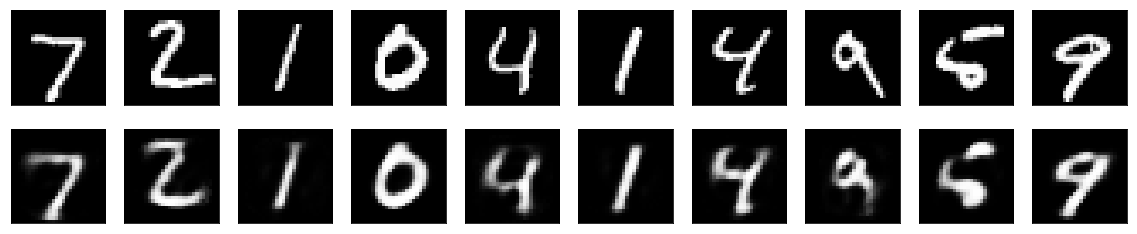

In [9]:
import matplotlib.pyplot as plt

n = 10 # 我們想展示圖像的數量
plt.figure(figsize=(20, 4))

for i in range(n):
    # 秀出原圖像
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 秀出重建圖像
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs_fc[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

以上是我們得到的結果。上面的一行是原始數字圖像，下面一行是重建的數字圖像。如果我們所說的這個autoencoder會失去很多細節(有損的壓縮)。

## 深度自動編碼器 (Deep autoencoder)

我們不必將自己限制在一個單獨的神經層上作為編碼器或解碼器，而是可以使用一堆神經層，例如：

In [10]:
input_img_deep = Input(shape=(784,))

encoded_deep = Dense(128, activation='relu')(input_img_deep)
encoded_deep = Dense(64, activation='relu')(encoded_deep)
encoded_deep = Dense(32, activation='relu')(encoded_deep)

decoded_deep = Dense(64, activation='relu')(encoded_deep)
decoded_deep = Dense(128, activation='relu')(decoded_deep)
decoded_deep = Dense(784, activation='sigmoid')(decoded_deep)

# 串接編碼(encoded)與解碼(decoded)的模型
autoencoder_deep = Model(input_img_deep, decoded_deep)

# 模型參數設定
autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy')

# 開始訓練模型
autoencoder_deep.fit(x_train, x_train,
               epochs=100,
               batch_size=256,
               shuffle=True,
               validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.3414 - val_loss: 0.2625
Epoch 2/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.2551 - val_loss: 0.2453
Epoch 3/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.2355 - val_loss: 0.2263
Epoch 4/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.2193 - val_loss: 0.2111
Epoch 5/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.2081 - val_loss: 0.2035
Epoch 6/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.1992 - val_loss: 0.1917
Epoch 7/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.1875 - val_loss: 0.1815
Epoch 8/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.1797 - val_loss: 0.1763
Epoch 9/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.1742 - val_loss: 0.1

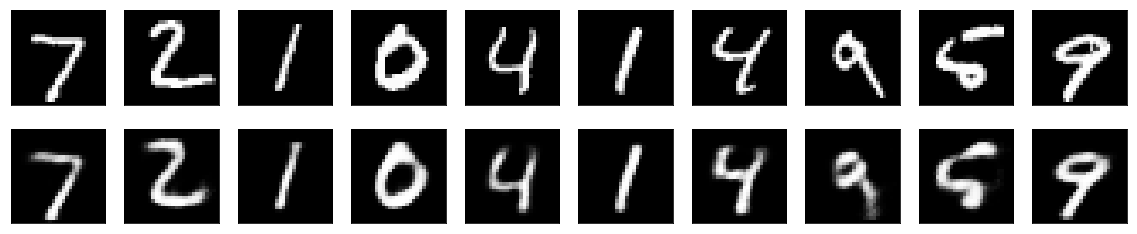

In [11]:
# 編碼與解碼一些手寫數字圖像
decoded_imgs_deep = autoencoder_deep.predict(x_test)

n = 10 # 我們想展示圖像的數量
plt.figure(figsize=(20, 4))

for i in range(n):
    # 秀出原圖像
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 秀出重建圖像
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs_deep[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## 卷積自動編碼器 (Convolutional autoencoder)

由於我們的輸入是圖像，所以使用卷積神經網絡（convnets）作為編碼器和解碼器是有意義的。在實際設置中，應用於圖像的自動編碼器始終是卷積自動編碼器 - 它們只是表現得更好。

我們來實現一個。編碼器將包含一堆Conv2D和MaxPooling2D層（最大池用於空間向下採樣down-sampling），而解碼器將包含一堆Conv2D和UpSampling2D層。

In [12]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Model

input_img_cov = Input(shape=(28, 28, 1)) # 使用`channels_first`圖像數據格式

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img_cov)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded_cov = MaxPool2D((2, 2), padding='same')(x)

# 到這個節點的編碼表示的結構是 (4, 4, 8), 也可以想成是 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_cov)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded_cov = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# 串接編碼(encoded)與解碼(decoded)的模型
autoencoder_cov = Model(input_img_cov, decoded_cov)

# 模型參數設定
autoencoder_cov.compile(optimizer='adadelta', loss='binary_crossentropy')

# 秀出模型結構
autoencoder_cov.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

為了訓練它，我們將使用原始MNIST數字（樣本,28,28），並且我們僅對像素值進行歸一化讓數值落在0和1之間。

In [13]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # 使用`channels_first`圖像數據格式
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # 使用`channels_first`圖像數據格式

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


讓我們訓練這個模型50個循環。為了演示如何在訓練過程中顯示模型的結果，我們將使用TensorFlow後端和TensorBoard回調。

首先，打開一個終端並啟動一個TensorBoard服務器，該服務器將讀取存儲在/tmp/autoencoder中的日誌。

In [14]:
# 開始訓練模型
autoencoder_cov.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 97us/step - loss: 0.2409 - val_loss: 0.1732
Epoch 2/50
60000/60000 [==============================] - 5s 75us/step - loss: 0.1648 - val_loss: 0.1551
Epoch 3/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1477 - val_loss: 0.1390
Epoch 4/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1376 - val_loss: 0.1317
Epoch 5/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1313 - val_loss: 0.1305
Epoch 6/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.1264 - val_loss: 0.1224
Epoch 7/50
60000/60000 [==============================] - 4s 67us/step - loss: 0.1235 - val_loss: 0.1205
Epoch 8/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.1209 - val_loss: 0.1187
Epoch 9/50
60000/60000 [==============================] - 5s 76us/step - loss: 0.1192 - val_loss: 0.1189
Epoch

該模型收斂到0.094的損失，明顯好於我們之前的模型（這在很大程度上是由於編碼表示的更高的熵容量，128維度與之前的32維度）。我們來看看重建的數字圖像：

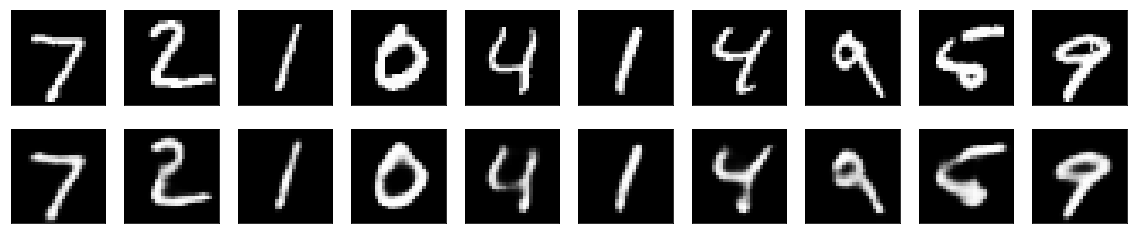

In [15]:
decoded_imgs_conv = autoencoder_cov.predict(x_test)

n = 10 # 我們想展示圖像的數量
plt.figure(figsize=(20, 4))

for i in range(n):
    # 秀出原圖像
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 秀出重建圖像
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs_conv[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## 應用於圖像去噪 (image denoising)

讓我們把我們的卷積自動編碼器工作在一個圖像去噪問題。這很簡單：我們將訓練自動編碼器將噪聲數字圖像處理成清晰的數字圖像。

以下是我們如何生成合成噪聲數字圖像：我們只是應用高斯噪聲矩陣，並在0和1之間剪切圖像。

In [16]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # 使用`channels_first`圖像數據格式
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # 使用`channels_first`圖像數據格式

noise_factor = 0.5 # 噪點因子
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

以下是有噪點的數字圖像：

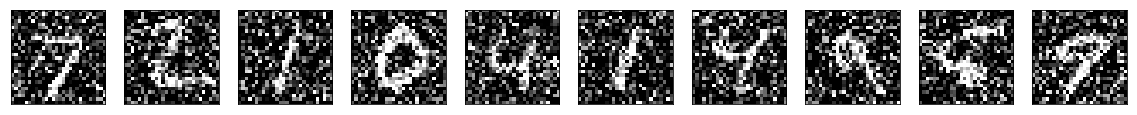

In [17]:
n = 10
plt.figure(figsize=(20, 2))

for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

如果你瞇起眼睛，你仍然勉強可以認出他們。我們的自動編碼器能學會如何恢復原始數字圖像嗎？讓我們試試看。

與上一個的捲積自動編碼器相比，為了提高重建質量，我們將使用稍微不同的模型，每層有更多的濾波器：

In [18]:
input_img_conv2 = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img_conv2)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded_conv2 = MaxPool2D((2, 2), padding='same')(x)

# 到這個節點的編碼表示的結構是 (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_conv2)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded_conv2= Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# 串接編碼(encoded)與解碼(decoded)的模型
autoencoder_conv2 = Model(input_img_conv2, decoded_conv2)

# 模型參數設定
autoencoder_conv2.compile(optimizer='adadelta', loss='binary_crossentropy')

# 模型參數設定
autoencoder_conv2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 32)        0         
__________

讓我們訓練它100個循環：

In [19]:
autoencoder_conv2.fit(x_train_noisy, x_train,
                     epochs=100,
                     batch_size=128,
                     shuffle=True,
                     validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 97us/step - loss: 0.2192 - val_loss: 0.1322
Epoch 2/100
60000/60000 [==============================] - 5s 85us/step - loss: 0.1264 - val_loss: 0.1170
Epoch 3/100
60000/60000 [==============================] - 5s 88us/step - loss: 0.1162 - val_loss: 0.1110
Epoch 4/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.1113 - val_loss: 0.1074
Epoch 5/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.1085 - val_loss: 0.1062
Epoch 6/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.1065 - val_loss: 0.1035
Epoch 7/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.1049 - val_loss: 0.1023
Epoch 8/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.1039 - val_loss: 0.1021
Epoch 9/100
60000/60000 [==============================] - 6s 97us/step - loss: 0.1029 - val_loss: 0.1

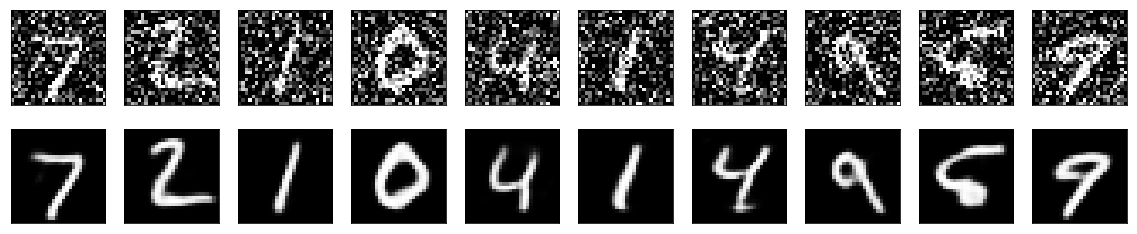

In [20]:
decoded_imgs_conv2 = autoencoder_conv2.predict(x_test_noisy)

n = 10 # 我們想展示圖像的數量
plt.figure(figsize=(20, 4))

for i in range(n):
    # 秀出原圖像
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 秀出重建圖像
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs_conv2[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

現在我們來看看結果。第一行展現的是有噪點的數字圖像，以及第二行由網絡重建的數字圖像。
它似乎效果很好。如果您將此過程擴展為更大的卷積網絡，那麼就可以開始構建文檔去噪或音頻去噪的模型。

## 總結 (Conclusion)

在這篇文章中有一些個人學習到的一些有趣的重點:
* Autoencoder的概念在深度學習有很多的應用, 不管是在圖像、語音甚至自然語言的處理上
* 了解autoencoder的構建可以做為學習構建更複雜的深度學習的網絡結構

參考:
* [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.